In [1]:
import os, sys
os.chdir(os.path.abspath('..'))

In [2]:
import json
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

In [3]:
%load_ext autoreload
%autoreload 2

from src.vae_models import CVAE
import src.utils as utils
import src.preprocess_lib as preprocess_lib
import src.testing_lib as testing_lib


### Find the desired model

In [20]:
config_dir = '/home/kbolat/Python/behavio-temporal-vae/runs/sweep_runs/sweep_Jul31_12-40-23'
config_file = 'config.json'

with open(os.path.join(config_dir, config_file), 'r') as f: config = json.load(f)

In [21]:
trainset, valset, conditioner, user_ids, condition_set, X_test, nonzero_mean, nonzero_std = preprocess_lib.prepare_data(config["data"])

Dataset: goi4_dp_full_Gipuzkoa
Loaded 2522880 consumption profiles from 365 dates and 6912 users.
Loaded metadata for 1 provinces
Uniqe provinces are: ['Gipuzkoa']
Removing 15 users with all-zero consumption profiles
Removing 67 users with any-negative consumption profiles
Number of (subsampled/filtered) users....6830
Number of (subsampled) days...............365
Number of (aggregated) features............24
Mean of enrolments: 10.06
Number of Training Points: 2180883
Number of Validation Points: 242320


In [22]:
num_missing_days = [x.shape[0] for x in X_test["list"]]
num_users = len(num_missing_days)

#### Visualize the enrolments

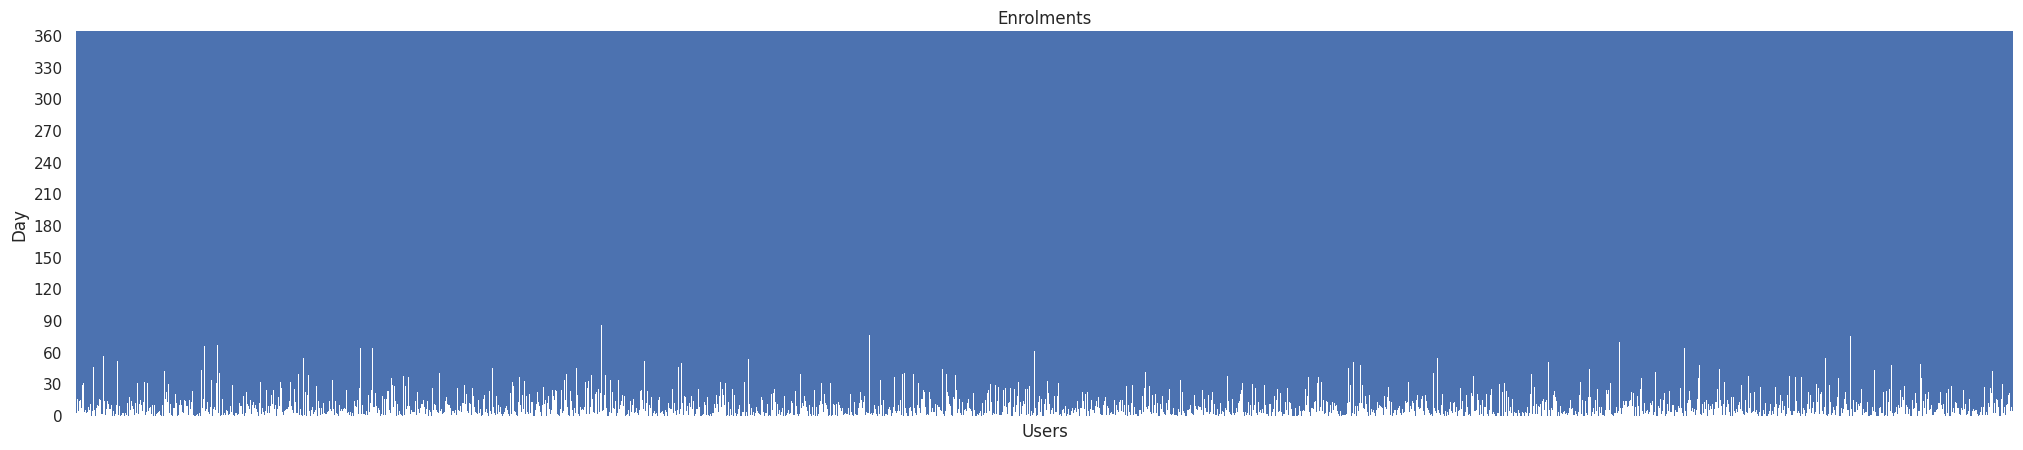

In [23]:
enrolment_matrix = np.zeros((num_users, 365))
for i in range(num_users): enrolment_matrix[i, num_missing_days[i]:] = 1

ssample = 1 ## for visualization
fig, ax = plt.subplots(1, 1, figsize=(25, 5))
sns.heatmap(enrolment_matrix[::ssample].T, ax=ax, cbar=False, cmap=["w", "b"])
ax.set_title("Enrolments")
ax.set_xlabel("Users")
ax.set_ylabel("Day")
plt.gca().invert_yaxis() ## flip the y axis
plt.yticks(np.arange(0, 365, 30), np.arange(0, 365, 30))
## remove xticks
plt.xticks([])
# plt.xticks(np.arange(0, num_users, num_users//(10*ssample)), np.arange(0, num_users, num_users//(10*ssample)))
plt.show()

### Load the model

In [24]:
# Load model
model = CVAE(input_dim=valset.inputs.shape[1], conditioner=conditioner, **config["model"])
model.load(config_dir)

USING SIGMA_LIM!
USING SIGMA_LIM!


### Prepare the data

In [25]:
log_space = config["data"]["scaling"]["log_space"]
zero_id = config["data"]["scaling"]["zero_id"]
shift = config["data"]["scaling"]["shift"]

In [26]:
x_test = utils.zero_preserved_log_normalize(X_test["flat"]*1.0, nonzero_mean, nonzero_std, log_output=log_space, zero_id=zero_id, shift=shift)
x_test = torch.tensor(x_test).float()

In [27]:
conditions_test =  torch.tensor(conditioner.transform(condition_set["test"].copy())).float()

### Inference

In [28]:
device = "cuda:1"

#### Reconstructions (for probabilistic metrics)

In [29]:
NUM_REC_SAMPLES = 100
x_rec, z_rec = testing_lib.mass_reconstruction(model, x_test, conditions_test, num_mc_samples=NUM_REC_SAMPLES, device=device)

#### Guided samples (for samaple-based metrics)

In [14]:
NUM_IMP_SAMPLES = {"prior": 20, "likelihood": 5}
x_imp = testing_lib.mass_imputation(model, conditions_test, num_mc_samples_prior=NUM_IMP_SAMPLES["prior"], num_mc_samples_likelihood=NUM_IMP_SAMPLES["likelihood"], device=device)

#### Probabilistic metrics

In [40]:
prob_metrics = testing_lib.get_probabilistic_metrics(model, x_test, x_rec, z_rec, aggregate=False, device=device)

In [32]:
model

CVAE(
  (encoder): GaussianNN(
    (parameterizer): ParameterizerNN(
      (block_dict): ModuleDict(
        (input): NNBlock(
          (input_layer): Sequential(
            (0): Linear(in_features=28, out_features=1000, bias=True)
            (1): ReLU()
            (2): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          )
          (middle_layers): ModuleList(
            (0-1): 2 x Sequential(
              (0): Linear(in_features=1000, out_features=1000, bias=True)
              (1): ReLU()
              (2): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            )
          )
          (output_layer): Sequential(
            (0): Linear(in_features=1000, out_features=1000, bias=True)
            (1): ReLU()
            (2): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          )
        )
        (mu): NNBlock(
          (input_layer): Sequential(
            (0)

In [33]:
x_rec["params"]["mu"].shape

torch.Size([100, 69747, 24])

In [30]:
x_test.shape

torch.Size([69747, 24])

In [25]:
prob_metrics

{'loglikelihood': array([ -6.1272707,  -9.177876 ,  -9.434548 , ...,  -4.0388966,
         -9.290643 , -11.893768 ], dtype=float32),
 'elbo': array([ -6.346203,  -9.241702,  -9.831465, ...,  -4.588015,  -9.566098,
        -12.632727], dtype=float32)}

#### Imputation and RMSE estimates

In [17]:
x_imp_denormalized = testing_lib.mass_denormalization(model=model, x_imp=x_imp, nonzero_mean=nonzero_mean, nonzero_std=nonzero_std, zero_id=zero_id, shift=shift, log_space=log_space, deviation=2, device=device)

In [18]:
IMPUTATION_STYLE = "mean" ## "samples" or "mean"
sample_metrics = testing_lib.get_sample_metrics(x_test, x_imp_denormalized, imputation_style=IMPUTATION_STYLE, aggregate=False)

In [19]:
sample_metrics

{'rmse': array([228.98636, 462.86792, 210.8696 , ..., 466.31494, 298.95044,
        495.8681 ], dtype=float32)}

#### Per user investigation

In [20]:
prob_metric_stats = {}
sample_metric_stats = {}

In [21]:
prob_metric_stats["elbo"] = testing_lib.get_per_user_metrics(prob_metrics["elbo"], user_ids["test"], num_users=num_users, summary=False)
prob_metric_stats["loglikelihood"] = testing_lib.get_per_user_metrics(prob_metrics["loglikelihood"], user_ids["test"], num_users=num_users, summary=False)
sample_metric_stats["rmse"] = testing_lib.get_per_user_metrics(sample_metrics["rmse"], user_ids["test"], num_users=num_users, summary=False)

In [22]:
prob_metric_stats["loglikelihood"]

[array([-6.1272707], dtype=float32),
 array([], dtype=float32),
 array([ -9.177876,  -9.434548, -11.579203], dtype=float32),
 array([-6.7868643], dtype=float32),
 array([-23.901855, -23.402401, -11.006717, -17.059437, -12.301688,
        -18.768063, -17.514236, -13.483878, -11.751797], dtype=float32),
 array([-13.701877 , -11.289882 , -17.90266  , -16.05265  ,  -7.5376334,
         -6.7917666, -15.508271 , -12.5861225,  -8.152363 , -17.479198 ,
        -14.908906 , -17.602386 , -15.730433 , -10.013138 , -11.053567 ,
        -17.998089 ,  -8.452533 ], dtype=float32),
 array([ 16.737186,  28.695034,  28.657818,  28.75098 ,  28.997982,
         28.651257,  11.629561,  16.003231,  16.357998,  28.723831,
         28.460278,  29.617065,  28.637901,  13.891679,   2.824998,
         28.604881,  28.558872,  28.424454,  -1.47475 ,  28.545826,
         28.675022,  15.979098,  16.393604, -15.023382,  24.014973,
         11.417611,  28.66127 ,  16.030018,  15.369296,  28.50639 ,
         28.507202,

In [23]:
testing_lib.get_perplexity(prob_metrics["loglikelihood"], num_missing_days)

1057.9771850026648

TypeError: list indices must be integers or slices, not str

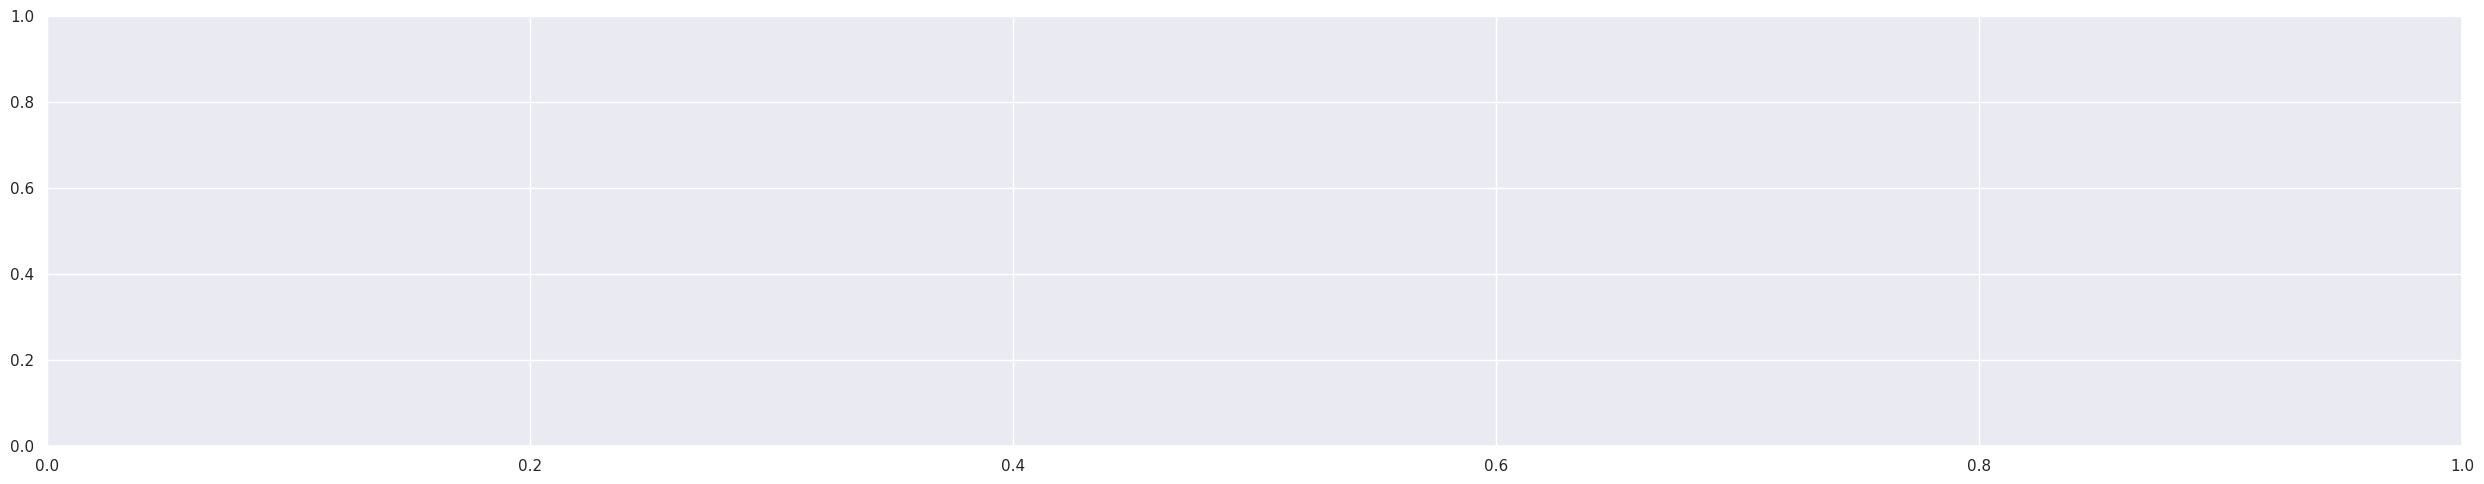

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(25, 5))
fig.tight_layout()
ax.plot(np.arange(num_users)[::100], (sample_metric_stats["rmse"]["median"])[::100], alpha=1)
ax.fill_between(np.arange(num_users)[::100], (sample_metric_stats["rmse"]["min"])[::100], (sample_metric_stats["rmse"]["max"])[::100], alpha=0.5)
ax.fill_between(np.arange(num_users)[::100], (sample_metric_stats["rmse"]["quartile_upper"])[::100], (sample_metric_stats["rmse"]["quartile_lower"])[::100], alpha=0.75)


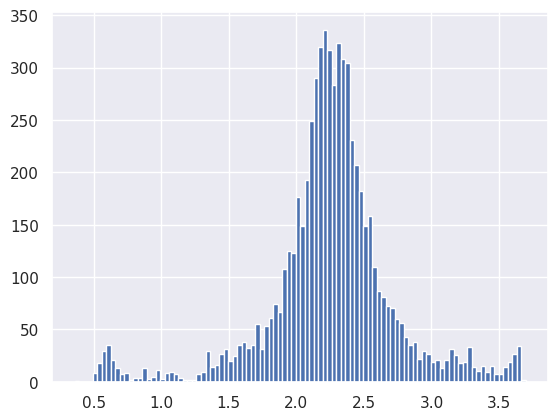

In [ ]:
plt.hist(np.log10(sample_metric_stats["rmse"]["median"]), bins=100)
plt.show()